In [1]:
import argparse
import numpy as np
import os
import tabulate
import torch
import torch.nn.functional as F
import torch.nn

import data
import models
import curves
import utils

import pickle
from pylab import rcParams

In [2]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from scipy.stats import norm

import utils
import time
from torch import nn
import seaborn as sns
from sklearn.manifold import TSNE

In [3]:
architecture = getattr(models, "LinearOneLayer")

model = architecture.base(num_classes=10, **architecture.kwargs)

loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True)

criterion = F.cross_entropy
regularizer = None 


architecture = getattr(models, "LinearOneLayer") #LinearOneLayer LogRegression
model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)
model3 = architecture.base(num_classes=10, **architecture.kwargs)
model4 = architecture.base(num_classes=10, **architecture.kwargs)

You are going to run models on the test set. Are you sure?


In [7]:
model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining//curve6/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining//curve8/checkpoint-30.pt')['model_state'])

model3.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve6/checkpoint-0.pt')['model_state'])
model4.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve8/checkpoint-0.pt')['model_state'])

# look_at_models(model1, model2, model3, model4, architecture)

In [8]:
# model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve5/checkpoint-30.pt')['model_state'])
# model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve6/checkpoint-30.pt')['model_state'])

# model3.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve5/checkpoint-0.pt')['model_state'])
# model4.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve6/checkpoint-0.pt')['model_state'])


In [9]:
def get_model(W, B, architecture):
    model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
    model_samples = np.array(W) #.cpu().data.numpy()
    SIZE = model_sampled.middle_dim

    offset = 0
    for parameter in list(model_sampled.parameters())[:-1]:
        size = int(np.prod(parameter.size())/SIZE)
        value = model_samples[:, offset:offset+size]
        if size==10 or size==1:
             value = value.T
#         print(value.shape)
        value = value.reshape(parameter.size())
#         print(value.shape)
        parameter.data.copy_(torch.from_numpy(value))
        offset += size

    list(model_sampled.parameters())[-1].data.copy_(B.mean(0)) #torch.from_numpy(
    
    return model_sampled

def test(model):
    criterion = F.cross_entropy
    regularizer = None 
    train_res = utils.test(loaders['train'], model, criterion, regularizer)
    test_res = utils.test(loaders['test'], model, criterion, regularizer) 
    print(train_res)
    print(test_res)

def samples(model):
    p1 = list(model.parameters())[0].data.cpu().numpy()
    p2 = list(model.parameters())[1].data.cpu().numpy()
    p3 = list(model.parameters())[2].transpose(0,1).data.cpu().numpy()
    samples = np.hstack([p1, p2[:, None], p3])
    
    return samples

In [10]:
def get_vector(model1):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    return par1

In [11]:
def distance(model1, model2):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    par2 = np.concatenate([p.data.cpu().numpy().ravel() for p in model2.parameters()])
    u = par2 - par1
    dx = np.linalg.norm(u)
    return dx

In [12]:
class distribution():
    def __init__(self, X):
        self.sorted_X = np.sort(X)
        self.uniform = np.arange(len(X)+1)/len(X)
        
    
    def F(self, x):
        b = self.sorted_X>=x
        ind = np.argmax(b)
#         print(ind)
#         print(b)
        if ~b[-1] and ind==0:
            return 1
        elif b[0] and ind==0:
            return 0
        else:
            delta = (x-self.sorted_X[ind-1])/(self.sorted_X[ind]-self.sorted_X[ind-1])
            return self.uniform[ind]+delta*(1/len(self.sorted_X))

    def inv_F(self, u):
        
        b = self.uniform[1:]>=u
        ind = np.argmax(b)
#         print(b)
#         print(ind)
#         print(len(self.sorted_X))
        if b[-1] and ind==(len(self.sorted_X)-1):
            return self.sorted_X[-1]
        elif b[0] and ind==0:
            return self.sorted_X[0]
        else:
#             print('u', self.uniform[ind])
            delta = (u-self.uniform[ind])/(1/len(self.sorted_X))
#             print('delta', delta)
            return self.sorted_X[ind-1]+delta*(self.sorted_X[ind]-self.sorted_X[ind-1])


In [13]:
S1 = samples(model1)
S2 = samples(model2)

In [14]:
S = np.vstack([S1, S2])
S.shape

(4000, 795)

In [15]:
def f(Z):
    X, All = Z
    distr = distribution(All)
    u = []
    for x in X:
        u.append(distr.F(x))
        
    return np.array(u)

def g(Z):
    
    X, U = Z
    distr = distribution(X)
    u = []
    for x in U:
        u.append(distr.inv_F(x))
        
    return  np.array(u)

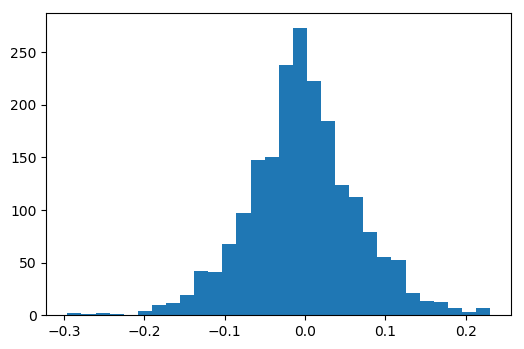

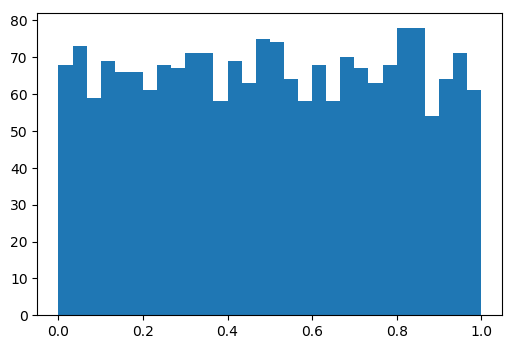

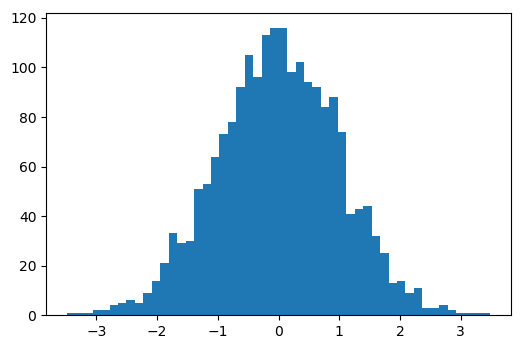

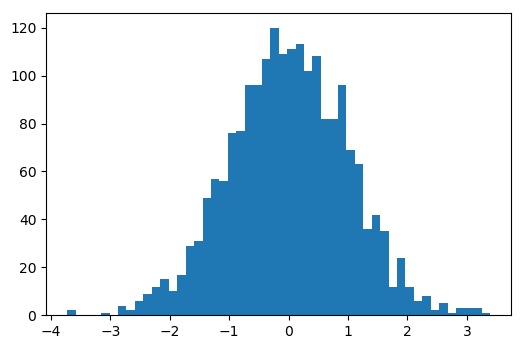

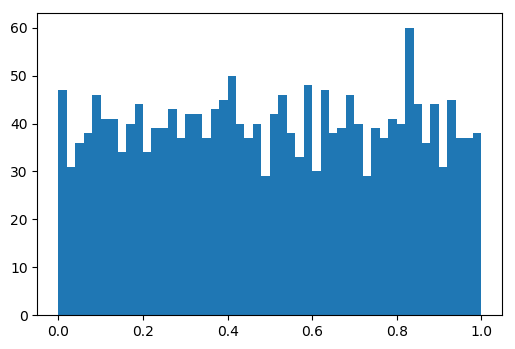

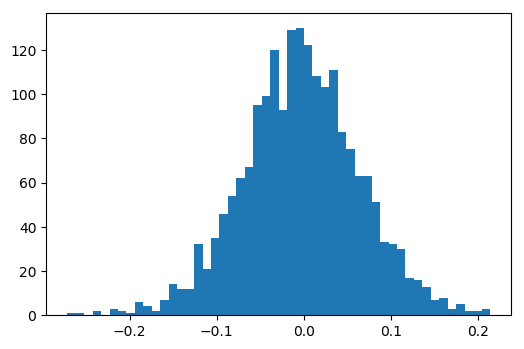

In [45]:
ind = -4
rcParams['figure.dpi'] = 100
plt.hist(S2[:, ind], bins=30);
plt.show()
plt.hist(res2[:, ind], bins=30);
plt.show()
plt.hist(nres2[:, ind], bins = 50);
plt.show()
plt.hist(nfin[:, ind], bins = 50); 
plt.show()
plt.hist(ufin[:, ind], bins = 50); 
plt.show()
plt.hist(PS_fin[:, ind], bins = 50);  
plt.show()

In [17]:
import sklearn

In [18]:
from sklearn.decomposition import PCA

In [21]:
def get_par(S, mean):
    new_S = S - mean
    cov = new_S.T @ new_S
    U, sigma, V = np.linalg.svd(cov)
    return U, sigma

def get_new_S(S, U, mean):
    new = (S-mean)@U
    return new

def get_inverse_new_S(V, U, mean):
#     S = (U @ V.T).T+mean
    S = V@np.linalg.inv(U)+mean
#     S = V@U2_temp.T*np.sqrt(sigma1)@U1.T*+mean
    return S

In [64]:
ebs = 0.

mean1 = S1.mean(0)
mean2 = S2.mean(0)
mmean = S.mean(0)

K = 795
# transPSA1 = PCA(n_components = K)
# transPSA2 = PCA(n_components = K)
transPSA = PCA(n_components = K)

# PS1 = transPSA1.fit_transform(S1)
# PS2 = transPSA1.fit_transform(S2)
SPS = transPSA.fit_transform(S-mmean)
SPS1 = transPSA.transform(S1-mmean)
SPS2 = transPSA.transform(S2-mmean)

SPS = S
SPS1 = S1
SPS2 = S2

SPS = S-mmean
SPS1 = S1-mmean
SPS2 = S2-mmean

# mean = 0

# U1, sigma1 = get_par(SPS1, mean)
# U2, sigma2 = get_par(SPS2, mean)
# U, _ = get_par(SPS, mean)

# U_temp = U1*(1/np.sqrt(sigma1+ebs))

# S2_temp = (SPS2-mean)@U_temp
# U2_temp, sigma2_temp = get_par(S2_temp, 0)
# U = U_temp@U2_temp

# PS11 = get_new_S(SPS1, U_temp, mean)
# PS111 = get_new_S(PS11, U2_temp, 0)
# *(1/np.sqrt(sigma2+0.01))

# PS1 = get_new_S(SPS1, U, mean)
# PS2 = get_new_S(SPS2, U, mean)
# PS = get_new_S(SPS, U, mean)


# PS1 = S1
# PS2 = S2

#inverse
# S1 = U @ PS1.T+mean

In [65]:
PS1 = SPS1
PS2 = SPS2
PS = SPS

In [66]:
PS1.shape, PS.shape

((2000, 795), (4000, 795))

In [67]:
# def constract_U(S1, S2, S):
    
#     mean1 = S1.mean(0)
#     mean2 = S2.mean(0)
#     mean = S.mean(0)
    
#     SPS = S
#     SPS1 = S1
#     SPS2 = S2

#     U1, sigma1 = get_par(SPS1, mean)
#     U2, sigma2 = get_par(SPS2, mean)
#     U, _ = get_par(SPS, mean)

#     U_temp = U1*(1/np.sqrt(sigma1+ebs))

#     S2_temp = (SPS2-mean)@U_temp
#     U2_temp, sigma2_temp = get_par(S2_temp, 0)
#     U = U_temp@U2_temp

#     # PS11 = get_new_S(SPS1, U_temp, mean)
#     # PS111 = get_new_S(PS11, U2_temp, 0)
#     # *(1/np.sqrt(sigma2+0.01))

#     PS1 = get_new_S(SPS1, U, mean)
#     PS2 = get_new_S(SPS2, U, mean)
#     PS = get_new_S(SPS, U, mean)
    
#     return U

In [68]:
# U1 = constract_U(S1, S2, S)
# U2 = constract_U(S2, S1, S)

In [69]:
# mean = mmean
# U = (U1+U2)
# U=U2
# PS1 = get_new_S(S1, U, mean)
# PS2 = get_new_S(S2, U, mean)
# PS = get_new_S(S, U, mean)

In [70]:
# # K = 700
# transPSA1 = PCA(n_components = K)
# transPSA2 = PCA(n_components = K)
# transPSA = PCA(n_components = K)

# # PS1 = transPSA1.fit_transform(S1)
# # PS2 = transPSA1.fit_transform(S2)
# # PS = transPSA.fit_transform(S)
# # PS1 = transPSA.transform(S1)
# # PS2 = transPSA.transform(S2)


# mean1 = S1.mean(0)
# mean2 = S1.mean(0)
# mean = S.mean(0)

# U1, sigma1 = get_par(S1, mean1)
# U2, sigma2 = get_par(S2, mean2)
# U, _ = get_par(S, mean)

# U_temp = (1/np.sqrt(sigma1))*U1

# S2_temp = (S2-mean2)@U_temp
# U2_temp, sigma2_temp = get_par(S2_temp, 0)
# # U = U_temp@U2_temp

# PS1 = get_new_S(S1, U1, mean1)
# PS2 = get_new_S(S2, U2, mean2)
# PS = get_new_S(S, U, mean)


# # PS1 = S1
# # PS2 = S2

# #inverse
# # S1 = U @ PS1.T+mean

In [71]:
(PS1.T@PS1)[0][:20]

array([ 0.7030486 ,  0.04101427,  0.01144511,  0.01326988, -0.00185434,
       -0.00894011, -0.0067679 ,  0.00130924, -0.01082845, -0.00163303,
        0.00683653,  0.01345853,  0.01093168, -0.02140704, -0.00898273,
       -0.0131399 ,  0.01477692, -0.01244958,  0.02444052,  0.00415961],
      dtype=float32)

In [72]:
(PS2.T@PS2)[0][:20]

array([ 0.727078  ,  0.02376222, -0.00190478,  0.04031616, -0.04862988,
        0.00431213, -0.024453  , -0.00413233,  0.02044014,  0.00907686,
        0.03443566, -0.01026399, -0.00687521,  0.01437629, -0.00720086,
        0.00852482,  0.02827173, -0.02652249, -0.00143928, -0.01155313],
      dtype=float32)

In [73]:
(PS.T@PS)[0][:10]

array([ 1.4301265 ,  0.06477649,  0.00954033,  0.05358604, -0.05048422,
       -0.00462799, -0.03122089, -0.00282309,  0.0096117 ,  0.00744382],
      dtype=float32)

In [74]:
TR1 = PS
TR2 = PS
TRF = PS

In [75]:
import multiprocessing
pool = multiprocessing.Pool(200)
res1 = np.array(pool.map(f, zip(PS1.T, TR1.T))).T
res2 = np.array(pool.map(f, zip(PS2.T, TR2.T))).T

In [76]:
res1.shape, res2.shape

((2000, 795), (2000, 795))

In [77]:
import scipy
from scipy.stats import norm

In [78]:
rv = norm()

In [79]:
nres1 = np.clip(rv.ppf(res1), -10, 10)
nres2 =  np.clip(rv.ppf(res2), -10, 10)

In [80]:
nres2.shape, nres1.shape

((2000, 795), (2000, 795))

In [81]:
nfin = 1/np.sqrt(2)*nres1+(1/np.sqrt(2))*nres2

ufin = rv.cdf(nfin)

fin = np.array(pool.map(g, zip(TRF.T, ufin.T))).T

# PS_fin = transPSA.inverse_transform(fin)

PS_fin = fin

# PS_fin = get_inverse_new_S(fin, U, mean) 

# PS_fin = transPSA.inverse_transform(PS_fin)

PS_fin +=mmean

In [82]:
B = []
B.append(list(model1.parameters())[-1].data.numpy())
B.append(list(model2.parameters())[-1].data.numpy())
B = torch.tensor(np.array(B))

model_inv = get_model(PS_fin, B, architecture)

test(model_inv)

{'nll': 0.08749410342375437, 'loss': 0.08749410342375437, 'accuracy': 97.75166666666667}
{'nll': 0.112172785282135, 'loss': 0.112172785282135, 'accuracy': 96.91}


In [42]:
test(model1)

{'nll': 0.04299221709916989, 'loss': 0.04299221709916989, 'accuracy': 99.02166666666666}
{'nll': 0.06919561448097229, 'loss': 0.06919561448097229, 'accuracy': 97.81}


In [1108]:
test(model1)

{'nll': 0.0429922171096007, 'loss': 0.0429922171096007, 'accuracy': 99.02166666666666}
{'nll': 0.06919561448097229, 'loss': 0.06919561448097229, 'accuracy': 97.81}


In [992]:
test(model2)

{'nll': 0.04327474986811479, 'loss': 0.04327474986811479, 'accuracy': 99.02833333333334}
{'nll': 0.06961786441802978, 'loss': 0.06961786441802978, 'accuracy': 97.95}


In [211]:
from scipy.stats import norm
rv = norm()

In [370]:
distr = distribution(S1)
print('X', distr.sorted_X.shape)
print('uni', distr.uniform.shape)
# x = [6]*795
x = 6
print(x)
print('u', distr.F(x))
print('x', distr.inv_F(distr.F(x)))

X (2000, 795)
uni (2001,)
6


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [251]:
distr = distribution(X)
print('X', distr.sorted_X)
print('uni', distr.uniform)
x = 6
print(x)
print('u', distr.F(x))
print('x', distr.inv_F(distr.F(x)))

X [1 2 5 7 9]
uni [0.  0.2 0.4 0.6 0.8 1. ]
6
u 0.7
x 6.0


In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
rcParams['figure.dpi'] = 100